<a href="https://colab.research.google.com/github/TAlkam/Mortality-Risk-Prediction-in-Alzheimer-s-Disease-ED-Encounters/blob/main/GitHub_version_of_Final_version_of_Red_flagging_risky_diseases_for_mortality_NEDS_2012_2014_balanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Top 30 ICD-9 Diagnosis Codes Among Alzheimer’s Patients: Frequency Analysis with Code Descriptions**

In [ ]:
# ============================================================
#  Colab cell – Top-30 ICD-9 codes for AD, with descriptions
# ============================================================
# 1) Install Stata reader
!pip install -q pyreadstat

# 2) Imports
import pandas as pd, re
from collections import Counter
from google.colab import files

# ------------------------------------------------------------
# 3) Upload files
#    Pick your .dta file (required) and the ICD-9 Excel workbook (optional)
print("⬆️  Choose your Stata dataset (.dta) *and* the ICD-9 description ")
uploaded = files.upload()

# ------------------------------------------------------------
# 4) Identify paths
try:
    stata_path = next(fp for fp in uploaded if fp.lower().endswith('.dta'))
except StopIteration:
    raise RuntimeError("❌ No .dta file uploaded – script cannot continue.")

desc_paths = [fp for fp in uploaded if fp.lower().endswith(('.xls', '.xlsx'))]
has_desc  = bool(desc_paths)
if has_desc:
    desc_path = desc_paths[0]

# ------------------------------------------------------------
# 5) Read Stata dataset
df_raw = pd.read_stata(stata_path)

# ------------------------------------------------------------
# 6) Read ICD-9 description workbook (if provided) and build lookup
icd9_lookup = {}
if has_desc:
    df_desc = pd.read_excel(desc_path, sheet_name=0)

    # Helper: find a column matching any regex in `patterns`
    def find_col(patterns, cols):
        for pat in patterns:
            for c in cols:
                if re.fullmatch(pat, c, flags=re.I):
                    return c
        return None

    # Patterns for common header names
    patterns_code  = [r'diag.*code', r'dx.*code', r'.*code', r'icd.*']
    patterns_long  = [r'long.*(desc|description)', r'(desc|description).*long']
    patterns_short = [r'short.*(desc|description)', r'(desc|description).*short']

    code_col  = find_col(patterns_code,  df_desc.columns)
    long_col  = find_col(patterns_long,  df_desc.columns)
    short_col = find_col(patterns_short, df_desc.columns)

    if not code_col:
        raise ValueError("Couldn't identify a column containing the ICD-9 code "
                         "in the workbook.")

    if not long_col and short_col:      # fall back to short description only
        long_col = short_col

    if not long_col:
        print("⚠️  No description columns found – tables will list codes only.")
    else:
        # Normalise: lower-case, strip spaces/dots
        df_desc['key'] = df_desc[code_col].astype(str)\
                             .str.lower().str.replace(r'\.', '', regex=True).str.strip()
        df_desc['description'] = df_desc[long_col]
        icd9_lookup = dict(zip(df_desc['key'], df_desc['description']))

# ------------------------------------------------------------
# 7) Settings
ALZ_FLAG, DEATH_FLAG = 'alz', 'died_binary'      # change if your column names differ
dx_cols = [c for c in df_raw.columns             # assume dx1-dx30, case-insensitive
           if re.fullmatch(r'dx\d+', c, flags=re.I)]

if not dx_cols:
    raise RuntimeError("No diagnosis columns (dx1, dx2, …) found in the dataset.")

# ------------------------------------------------------------
# 8) Helper to build top-N table
def top_codes(sub_df, n=30):
    # Stack dx1-dx30 into one long Series of codes
    codes = (
        sub_df[dx_cols]
        .astype(str)
        .stack()                       # turn wide → long
        .str.strip()
        .str.lower()
        .replace({'nan': ''})
    )
    # Normalise format: remove periods
    codes = codes.str.replace(r'\.', '', regex=True)
    counts = Counter([c for c in codes if c])     # exclude blanks
    tbl = pd.DataFrame(counts.most_common(n), columns=['ICD9_Code', 'Frequency'])
    if icd9_lookup:
        tbl['Description'] = tbl['ICD9_Code'].map(icd9_lookup)\
                                             .fillna('[description missing]')
    return tbl

# Only Alzheimer’s visits
df_ad = df_raw[df_raw[ALZ_FLAG] == 1].copy()

tables = {
    'ALL_AD_VISITS':       top_codes(df_ad),
    'DECEASED_AD_VISITS':  top_codes(df_ad[df_ad[DEATH_FLAG] == 1]),
    'SURVIVING_AD_VISITS': top_codes(df_ad[df_ad[DEATH_FLAG] == 0]),
}

# ------------------------------------------------------------
# 9) Print tables and save CSVs
for title, tbl in tables.items():
    print(f"\n=== {title.replace('_', ' ')} ===")
    print(tbl.to_string(index=False))

    fname = f"{title.lower()}.csv"
    tbl.to_csv(fname, index=False)

print("\n✓ Finished. The three CSV files are saved in the Colab file browser "
      "on the left (ALL_AD_VISITS.csv, DECEASED_AD_VISITS.csv, SURVIVING_AD_VISITS.csv).")


# **Risk Analysis of ICD-9 Codes in Alzheimer’s Patients: Prevalence, Risk Ratios, Confidence Intervals, and p-Values**

In [ ]:
# ============================================================
#  Cell 2 – prevalence, risk ratios & p-values
# ============================================================
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact

deaths_total = (df_ad[DEATH_FLAG] == 1).sum()
surv_total   = (df_ad[DEATH_FLAG] == 0).sum()

def code_stats(code_raw):
    """Return stats tuple for a single ICD-9 code string."""
    code = str(code_raw).strip().lower().replace('.', '')
    if code in ('', 'nan'):
        return None            # skip empty cells

    deaths_with = ((df_ad[DEATH_FLAG] == 1) &
                   (df_ad[dx_cols].eq(code).any(axis=1))).sum()
    surv_with   = ((df_ad[DEATH_FLAG] == 0) &
                   (df_ad[dx_cols].eq(code).any(axis=1))).sum()

    # Skip codes that never occur at all
    if (deaths_with + surv_with) == 0:
        return None

    deaths_without = deaths_total - deaths_with
    surv_without   = surv_total   - surv_with
    table = np.array([[deaths_with, deaths_without],
                      [surv_with,   surv_without]])

    # ---------- prevalence ----------
    prev_death = deaths_with / deaths_total
    prev_surv  = surv_with   / surv_total

    # ---------- p-value ----------
    try:
        chi2, p_val, _, _ = chi2_contingency(table, correction=True)
    except ValueError:
        # fall back to Fisher’s exact
        _, p_val = fisher_exact(table, alternative='two-sided')

    # ---------- RR + 95 % CI (Haldane–Anscombe) ----------
    # add 0.5 to each cell only if a zero is present
    if (table == 0).any():
        table_adj = table + 0.5
        rr = (table_adj[0,0] / table_adj[0].sum()) / (table_adj[1,0] / table_adj[1].sum())
        se = np.sqrt(1/table_adj[0,0] + 1/table_adj[1,0]
                     - 1/table_adj[0].sum() - 1/table_adj[1].sum())
    else:
        rr = prev_death / prev_surv if prev_surv else np.inf
        se = np.sqrt((1/deaths_with) - (1/deaths_total)
                     + (1/surv_with) - (1/surv_total))

    ci_low, ci_high = np.exp(np.log(rr) - 1.96*se), np.exp(np.log(rr) + 1.96*se)

    return (code, deaths_with, surv_with,
            prev_death*100, prev_surv*100,
            rr, ci_low, ci_high, p_val)

# ---------- build the table ----------
records = filter(None, (code_stats(code)
                        for code in pd.unique(df_ad[dx_cols].values.ravel('K'))))

cols = ['ICD9_Code', 'Deaths_with', 'Surv_with',
        'Prev_death_%', 'Prev_surv_%',
        'RiskRatio', 'CI_low', 'CI_high', 'p_value']
rr_df = pd.DataFrame.from_records(records, columns=cols)

# attach description if available
if icd9_lookup:
    rr_df['Description'] = rr_df['ICD9_Code'].map(icd9_lookup).fillna('')

# sort & display
rr_df = rr_df.sort_values('RiskRatio', ascending=False)
print("\n=== Risk ratio table (top 50) ===")
print(rr_df.head(50).to_string(index=False, formatters={
    'Prev_death_%': '{:.1f}'.format,
    'Prev_surv_%':  '{:.1f}'.format,
    'RiskRatio':    '{:.2f}'.format,
    'CI_low':       '{:.2f}'.format,
    'CI_high':      '{:.2f}'.format,
    'p_value':      '{:.2e}'.format}))

# save full output
rr_df.to_csv('icd9_risk_ratios_full.csv', index=False)
print("\n✓ Saved icd9_risk_ratios_full.csv for detailed review.")


# **Generating and Saving Top 25 High-Risk ICD-9 Codes Table for Alzheimer’s ED Mortality Analysis**

Retrieves or loads the full risk ratio dataset,

Filters the top 25 ICD-9 codes based on mortality risk,

Formats them for clarity,

Displays and exports the result for manuscript use.

In [ ]:
# =============================================================
#  Colab cell — Top-25 red-flag ICD-9 codes table (death vs. survival)
# =============================================================
import pandas as pd, os
from IPython.display import display

# -------------------------------------------------------------
# 1.  Get the full risk-ratio dataframe
#     • If rr_df is still in memory, use it.
#     • Otherwise read the CSV we saved earlier.
# -------------------------------------------------------------
if 'rr_df' in globals():
    df = rr_df.copy()
elif os.path.exists('icd9_risk_ratios_full.csv'):
    df = pd.read_csv('icd9_risk_ratios_full.csv')
else:
    raise RuntimeError("❌  No rr_df object or 'icd9_risk_ratios_full.csv' file found.\n"
                       "    Run the risk-ratio cell first, then rerun this one.")

# -------------------------------------------------------------
# 2.  Select the Top 25 rows by descending risk ratio
# -------------------------------------------------------------
top_n  = 25
top25  = df.sort_values('RiskRatio', ascending=False).head(top_n).copy()

# -------------------------------------------------------------
# 3.  Nicely format numeric columns for readability
# -------------------------------------------------------------
fmt_map = {
    'Prev_death_%': '{:.1f}',
    'Prev_surv_%':  '{:.1f}',
    'RiskRatio':    '{:.2f}',
    'CI_low':       '{:.2f}',
    'CI_high':      '{:.2f}',
    'p_value':      '{:.2e}',
}
for col, fmt in fmt_map.items():
    if col in top25.columns:
        top25[col] = top25[col].map(lambda x: fmt.format(x))

# -------------------------------------------------------------
# 4.  Re-order columns in a logical order (skip if missing)
# -------------------------------------------------------------
order = ['ICD9_Code', 'Description', 'Deaths_with', 'Surv_with',
         'Prev_death_%', 'Prev_surv_%',
         'RiskRatio', 'CI_low', 'CI_high', 'p_value']
top25 = top25[[c for c in order if c in top25.columns]]

# -------------------------------------------------------------
# 5.  Display the table
#     (plain display avoids hide_index issues on older pandas)
# -------------------------------------------------------------
display(top25)

# -------------------------------------------------------------
# 6.  Save a CSV you can download for the manuscript
# -------------------------------------------------------------
fname = 'Top25_redflag_ICD9_table.csv'
top25.to_csv(fname, index=False)
print(f"\n✓ Saved '{fname}'.  Download it from the file pane on the left.")


# **Calculating and Exporting Risk Ratios (RR) and Odds Ratios (OR) for All (25) ICD-9 Codes in Alzheimer’s ED Data**

Reconstructs 2×2 tables for each ICD-9 code,

Calculates both RR and OR (with 95% confidence intervals),

Displays the top 25 by RR,

Saves a complete table for publication or further analysis.

In [ ]:
# =============================================================
#  Colab cell – RR *and* OR for every ICD-9 code
# =============================================================
import numpy as np, pandas as pd, os
from scipy.stats import fisher_exact

# -------------------------------------------------------------
# 1.  Load the rr_df (risk-ratio) DataFrame if it exists;
#     otherwise read the CSV produced earlier.
# -------------------------------------------------------------
if 'rr_df' in globals():
    df_all = rr_df.copy()
elif os.path.exists('icd9_risk_ratios_full.csv'):
    df_all = pd.read_csv('icd9_risk_ratios_full.csv')
else:
    raise RuntimeError("Run the risk-ratio cell first to create icd9_risk_ratios_full.csv.")

# -------------------------------------------------------------
# 2.  Reconstruct counts from the stored columns
#     (deaths_with, surv_with, total deaths & survivors)
# -------------------------------------------------------------
deaths_total = (df_ad[DEATH_FLAG] == 1).sum()    # if df_ad still in RAM
surv_total   = (df_ad[DEATH_FLAG] == 0).sum()

if pd.isna(deaths_total) or pd.isna(surv_total):
    raise RuntimeError("Need df_ad in memory; if kernel was reset, reload your dataset.")

records = []
for _, row in df_all.iterrows():
    code         = row['ICD9_Code']
    deaths_with  = int(row['Deaths_with'])
    surv_with    = int(row['Surv_with'])
    deaths_without = deaths_total - deaths_with
    surv_without   = surv_total  - surv_with

    # --- add 0.5 to every cell if any zero -> Haldane-Anscombe correction
    table = np.array([[deaths_with,  deaths_without],
                      [surv_with,    surv_without]], dtype=float)
    if (table == 0).any():
        table += 0.5

    # --- RR (already computed, but recalc for completeness)
    prev_death = table[0,0] / table[0].sum()
    prev_surv  = table[1,0] / table[1].sum()
    rr = prev_death / prev_surv

    # --- OR
    or_val = (table[0,0] * table[1,1]) / (table[0,1] * table[1,0])

    # 95 % CI for OR (Woolf log method)
    se_log_or = np.sqrt(1/table[0,0] + 1/table[0,1] + 1/table[1,0] + 1/table[1,1])
    ci_low_or, ci_high_or = np.exp(np.log(or_val) - 1.96*se_log_or), \
                            np.exp(np.log(or_val) + 1.96*se_log_or)

    # Fisher exact p for reference
    _, p_two = fisher_exact(table, alternative='two-sided')

    records.append({
        'ICD9_Code': code,
        'Description': row.get('Description', ''),
        'Deaths_with': int(row['Deaths_with']),
        'Surv_with':   int(row['Surv_with']),
        'RR':  rr,
        'OR':  or_val,
        'OR_CI_low':  ci_low_or,
        'OR_CI_high': ci_high_or,
        'p_value': p_two
    })

rr_or_df = pd.DataFrame(records)

# -------------------------------------------------------------
# 3.  Nice formatting & display
# -------------------------------------------------------------
fmt = {'RR': '{:.2f}', 'OR': '{:.2f}', 'OR_CI_low': '{:.2f}', 'OR_CI_high': '{:.2f}', 'p_value': '{:.2e}'}
for c, f in fmt.items(): rr_or_df[c] = rr_or_df[c].map(lambda x: f.format(x))

# Show top 25 by RR (or change to 'OR' to sort by odds ratio)
top25_rr = rr_or_df.sort_values('RR', ascending=False).head(25).reset_index(drop=True)
from IPython.display import display
display(top25_rr)

# -------------------------------------------------------------
# 4.  Save full table to disk
# -------------------------------------------------------------
rr_or_df.to_csv('ICD9_RR_OR_full.csv', index=False)
print("✓ Saved 'ICD9_RR_OR_full.csv'.  You can download it from the file pane.")


# **Full ML Pipeline for Mortality Prediction in Alzheimer’s ED Visits: Model Training, Evaluation, and SHAP Interpretation with ICD-9 Codes**

Uploading and preprocessing a diagnosis-based dataset

Training four predictive models (Logistic Regression, Random Forest, Gradient Boosting, XGBoost)

Evaluating model performance with accuracy, precision, recall, F1, and AUROC

Interpreting the best model (XGBoost) using SHAP

Visualizing top ICD-9 features linked to mortality in Alzheimer’s patients

Saving publication-quality SHAP plots

⬆️  Upload balanced NEDS .dta file (must include *_bin flags and died_binary)


Saving balanced_alz_died_binary 23608 sample.dta to balanced_alz_died_binary 23608 sample (3).dta
✅ Loaded 23,608 encounters
Split sizes  ➜  Train: 14164  Val: 4722  Test: 4722

Validation metrics
              Model  Val_AUROC  Val_Prec  Val_Rec   Val_F1
  Gradient Boosting   0.853714  0.858611 0.743329 0.796822
            XGBoost   0.853395  0.855010 0.751800 0.800090
Logistic Regression   0.852988  0.881755 0.698009 0.779196
      Random Forest   0.852173  0.853647 0.753494 0.800450

🏆 Selected model: Gradient Boosting

Held-out TEST metrics
  AUROC    : 0.860
  Accuracy : 0.820
  Precision: 0.876
  Recall   : 0.745
  F1       : 0.806


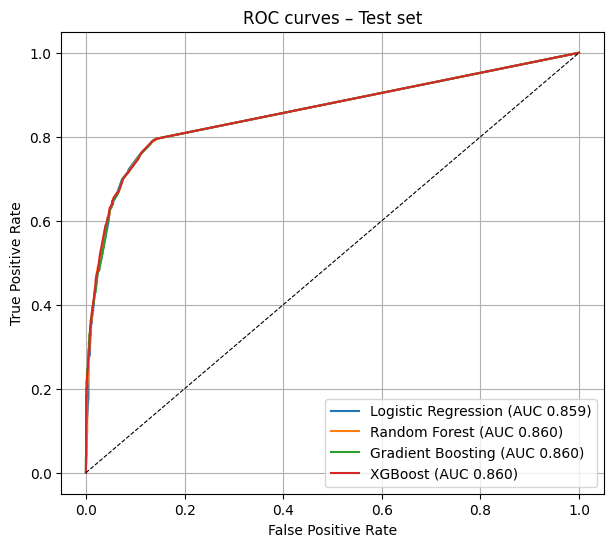

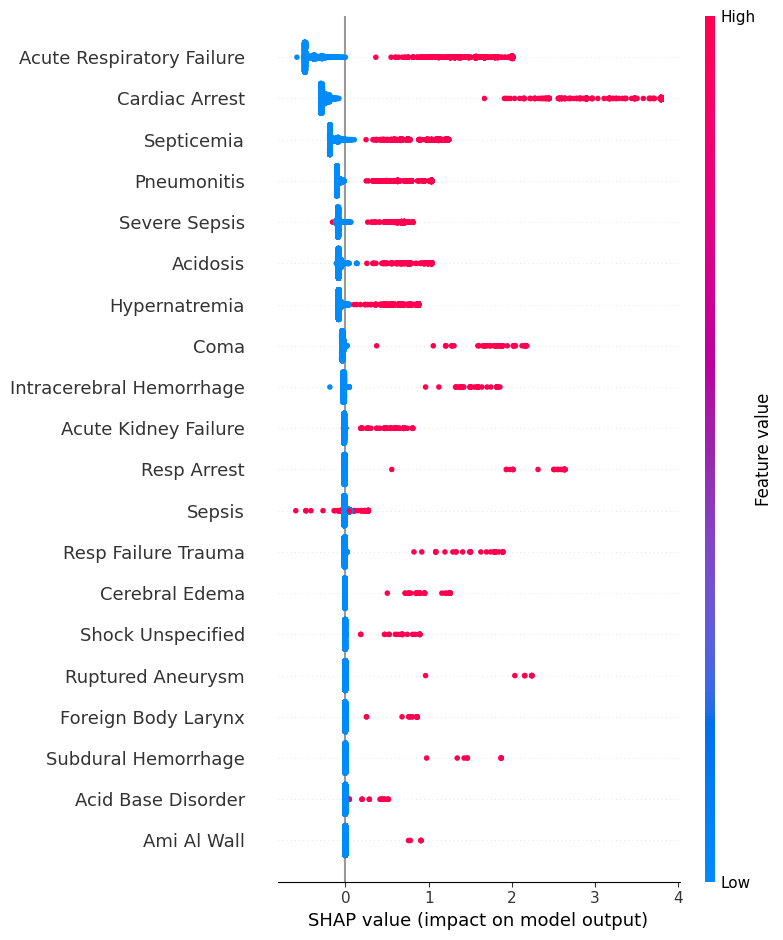

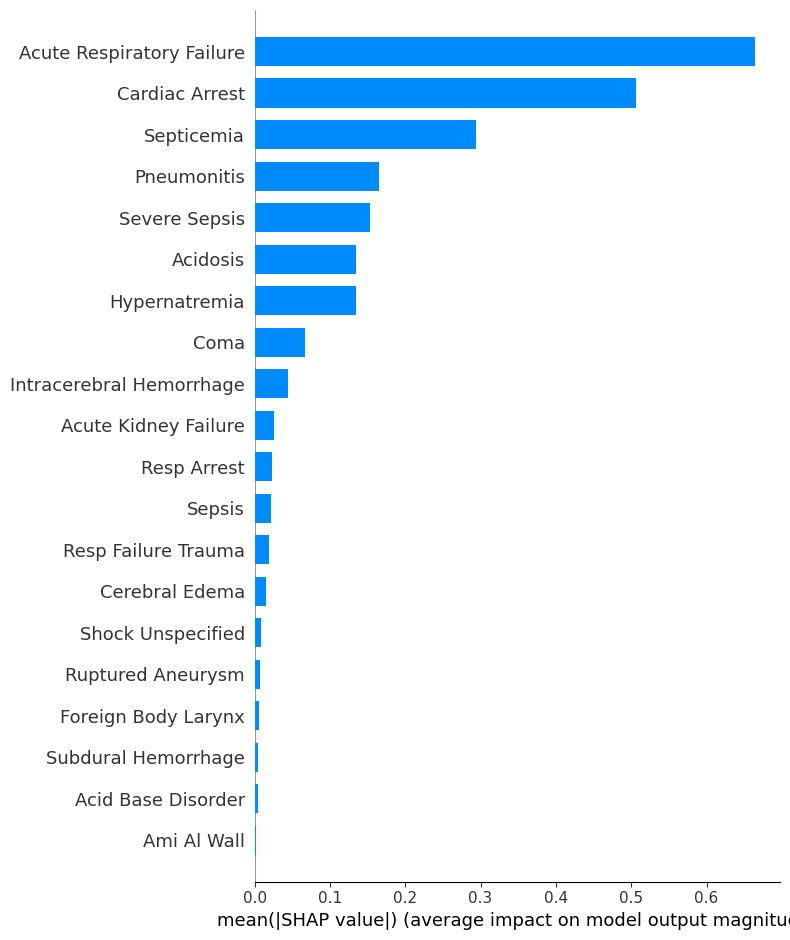


🔒 Model saved to models/gradient_boosting_alz.pkl


In [ ]:
# ===============================================================
#  Mortality Prediction in AD-Related ED Visits (NEDS 2012-2014)
#  • Train / Validation / Test (60 / 20 / 20)
#  • Four candidate models → choose best (AUROC on validation)
#  • Final evaluation on untouched test set
#  • SHAP feature interpretation with pretty labels
#  • Saves model + label map       — ready for reproducible research
# ===============================================================

# ────────────────────────────────────────────────────────────────
# 0 ▸ Install required packages (comment out if already installed)
# ────────────────────────────────────────────────────────────────
!pip install -q pyreadstat scikit-learn==1.5.0 xgboost==2.0.0 shap matplotlib pandas numpy joblib

# ────────────────────────────────────────────────────────────────
# 1 ▸ Imports
# ────────────────────────────────────────────────────────────────
import os, re, copy, joblib
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import pyreadstat, shap
from google.colab import files                          # remove if not in Colab
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# ────────────────────────────────────────────────────────────────
# 2 ▸ Data upload & preprocessing
# ────────────────────────────────────────────────────────────────
print("⬆️  Upload balanced NEDS .dta file (must include *_bin flags and died_binary)")
uploaded  = files.upload()                               # switch to input() if not using Colab
dta_file  = next(iter(uploaded))
with open(dta_file, "wb") as f: f.write(uploaded[dta_file])

df, _ = pyreadstat.read_dta(dta_file)
print(f"✅ Loaded {df.shape[0]:,} encounters")

# Select binary comorbidity flags
bin_vars = [c for c in df.columns
            if c.endswith('_bin') and df[c].dropna().nunique() <= 2]
dfm = df[bin_vars + ['died_binary']].dropna()
X, y = dfm[bin_vars], dfm['died_binary']

# ────────────────────────────────────────────────────────────────
# 3 ▸ Stratified Train / Val / Test split (60 / 20 / 20)
# ────────────────────────────────────────────────────────────────
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=42)

print(f"Split sizes  ➜  Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")

# ────────────────────────────────────────────────────────────────
# 4 ▸ Define candidate models
# ────────────────────────────────────────────────────────────────
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest":       RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1),
    "Gradient Boosting":   GradientBoostingClassifier(random_state=42),
    "XGBoost":             XGBClassifier(
                              use_label_encoder=False, eval_metric='logloss',
                              n_estimators=400, max_depth=5, learning_rate=0.05,
                              subsample=0.8, colsample_bytree=0.8,
                              random_state=42)
}

# ────────────────────────────────────────────────────────────────
# 5 ▸ Fit on Train, evaluate on Validation
# ────────────────────────────────────────────────────────────────
perf_records = []
for name, clf in models.items():
    clf.fit(X_train, y_train)
    val_pred = clf.predict(X_val)
    val_prob = clf.predict_proba(X_val)[:, 1]
    perf_records.append({
        "Model":       name,
        "Val_AUROC":   roc_auc_score(y_val, val_prob),
        "Val_Prec":    precision_score(y_val, val_pred),
        "Val_Rec":     recall_score(y_val, val_pred),
        "Val_F1":      f1_score(y_val, val_pred)
    })

perf_df = pd.DataFrame(perf_records).sort_values("Val_AUROC", ascending=False)
print("\nValidation metrics")
print(perf_df.to_string(index=False))

best_name = perf_df.iloc[0]["Model"]
best_clf_val = models[best_name]            # already fitted on Train
print(f"\n🏆 Selected model: {best_name}")

# ────────────────────────────────────────────────────────────────
# 6 ▸ Re-train winner on Train+Val, evaluate on Test
# ────────────────────────────────────────────────────────────────
X_tv, y_tv = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])
best_clf_tv = copy.deepcopy(best_clf_val).fit(X_tv, y_tv)

test_pred = best_clf_tv.predict(X_test)
test_prob = best_clf_tv.predict_proba(X_test)[:, 1]

print("\nHeld-out TEST metrics")
print(f"  AUROC    : {roc_auc_score(y_test, test_prob):.3f}")
print(f"  Accuracy : {accuracy_score(y_test, test_pred):.3f}")
print(f"  Precision: {precision_score(y_test, test_pred):.3f}")
print(f"  Recall   : {recall_score(y_test, test_pred):.3f}")
print(f"  F1       : {f1_score(y_test, test_pred):.3f}")

# ────────────────────────────────────────────────────────────────
# 7 ▸ ROC curves on Test (all models)
# ────────────────────────────────────────────────────────────────
plt.figure(figsize=(7,6))
for name, clf in models.items():
    # fit non-winners on Train+Val for fair test comparison
    if name != best_name:
        clf = copy.deepcopy(clf).fit(X_tv, y_tv)
    prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC {roc_auc_score(y_test, prob):.3f})")
plt.plot([0,1],[0,1],'k--', lw=0.8)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves – Test set"); plt.legend(); plt.grid(True); plt.show()

# ────────────────────────────────────────────────────────────────
# 8 ▸ SHAP interpretability with pretty labels
# ────────────────────────────────────────────────────────────────
def prettify(col):
    return re.sub(r'_bin$', '', col).replace('_', ' ').title()

nice = {c: prettify(c) for c in X.columns}
X_tv_nice   = X_tv.rename(columns=nice)
X_test_nice = X_test.rename(columns=nice)

if best_name in ["Gradient Boosting", "Random Forest", "XGBoost"]:
    explainer = shap.TreeExplainer(best_clf_tv)
    shap_vals = explainer.shap_values(X_test_nice)
else:
    explainer = shap.LinearExplainer(best_clf_tv, X_tv_nice)
    shap_vals = explainer.shap_values(X_test_nice)

shap.summary_plot(shap_vals, X_test_nice, plot_type='dot', max_display=20)
shap.summary_plot(shap_vals, X_test_nice, plot_type='bar', max_display=20)

# ────────────────────────────────────────────────────────────────
# 9 ▸ Save artefacts for reproducibility
# ────────────────────────────────────────────────────────────────
os.makedirs("models", exist_ok=True)
model_path = f"models/{best_name.lower().replace(' ','_')}_alz.pkl"
joblib.dump(best_clf_tv, model_path)                 # final model
joblib.dump(nice, "models/feature_name_map.pkl")     # for plotting
print(f"\n🔒 Model saved to {model_path}")
